In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import sys
helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

cmap = plt.get_cmap('viridis')
plt.rcParams['figure.dpi'] = 150

In [2]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7]) # surface pressure in dyn/cm^2
Tints = np.array([100, 150, 200, 250, 300, 350]) # internal temperature in K

CplusOs = np.array([1e-3, 1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.3, 0.59, 1.0, 1.2])

In [3]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None):
    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'Earth_P0={format_e_nums(loop_over)}_Tint={Tint}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'Earth_P0={format_e_nums(P0)}_Tint={loop_over}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}_NoCond_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'Earth_P0={format_e_nums(P0)}_Tint={Tint}_NoCond_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}'
    else:
        raise ValueError('Invalid loop_over value')

folder = '../output/EqChem/'

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, i_param=None):
        
    inds = []
    PTs = []
    nHtots = []
    data = []
    atoms = []
    mols = []
    supersats = []
    dusts = []
    mus = []

    for i, loop_over in enumerate(loop_overs):
        if i_param == None:
            name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO])
        else:
            name = built_name(loop_overs[i], P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], i_param=i_param)
        print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=j), dtype=int,  max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        d = np.loadtxt(path.format(var=j), skiprows=3)
        data.append(d)

        PTs.append(np.array([d[:,2]*1e-6, d[:,0]]).T) # convert pressure from dyn/cm^2 to bar
        nHtots.append(d[:,1])
        atoms.append(d[:,3:4+n_elem])
        mols.append(d[:,4+n_elem:4+n_elem+n_mol])
        supersats.append(d[:,4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        dusts.append(d[:,4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        inds.append(i)

        mu = path[:-21] + f'vertical_mix_{j}.dat'
        mu = np.loadtxt(mu, skiprows=1, usecols=3)
        mus.append(mu)

    return name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus

def convert(data, atoms, mols, dusts):
    n_tots = []
    for i in range(len(data)):
        n_tot = 10**data[i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        n_tots.append(n_tot[:,None])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(atoms):
        atom = 10**atom
        atoms[i] = atom / n_tots[i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(mols):
        mol = 10**mol
        mols[i] = mol / n_tots[i]

    #for i in range(len(supersats)):
    #    supersats[i] = 10**supersats[i]

    for i in range(len(dusts)):
        dusts[i] = 10**(dusts[i]) * nHtots[i][:,None] / n_tots[i]

    return n_tots, atoms, mols, dusts
 

In [4]:
i_P0 = 0 # i_param = 0
i_Tint = 0 # i_param = 1
i_CplusO = 2 # i_param = 2
i_CtoO = 0 # i_param = 3

loop_overs = CtoOs
i_param = 3
loop_name = params[i_param]
print(params[i_param])

# read data
name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus = extract_data(loop_overs, i_P0=i_P0, i_Tint=i_Tint, i_CplusO=i_CplusO, i_CtoO=i_CtoO, i_param=i_param)
n_tots, atoms, mols, dusts = convert(data, atoms, mols, dusts)

# convert name to array split by _
name = [n for n in name.split('_') if loop_name not in n]
# concatenate back together without loop_name
name = ', '.join(name).replace('plus', '+').replace('to', '/')
print(name)

CtoO
Earth_P0=1e6_Tint=100_NoCond_CplusO=3.16e-2_CtoO=0.1
Earth_P0=1e6_Tint=100_NoCond_CplusO=3.16e-2_CtoO=0.3
Earth_P0=1e6_Tint=100_NoCond_CplusO=3.16e-2_CtoO=0.59
Earth_P0=1e6_Tint=100_NoCond_CplusO=3.16e-2_CtoO=1.0
Earth_P0=1e6_Tint=100_NoCond_CplusO=3.16e-2_CtoO=1.2
Earth, P0=1e6, Tint=100, NoCond, C+O=3.16e-2


177.551
220.374
219.525
218.421
217.928


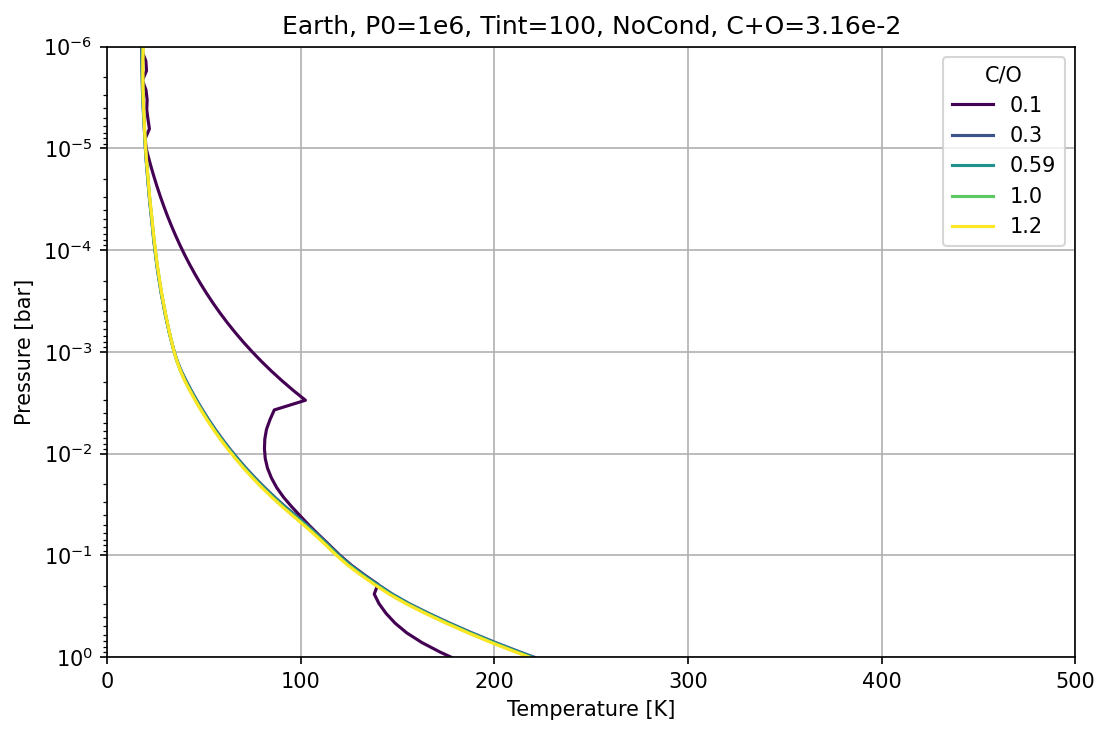

In [5]:
def plot_TP(loop_overs, PTs, inds, name, show_diff=False):
    """
    Plot Temperature-Pressure profiles.

    Parameters:
    - loop_overs: array of loop over variables
    - PTs: list of pressure-temperature arrays
    - inds: list of indices
    - name: title name for the plot
    - show_diff: bool, whether to show differences in a separate subplot
    """
    if show_diff:
        # Create a figure with two subplots: main plot and difference plot
        fig, (ax1, ax2) = plt.subplots(
            1, 2, 
            gridspec_kw={'width_ratios': [3, 1]}, 
            figsize=(10, 5)
        )
    else:
        # Create a single subplot
        fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))

    start = 0
    step = 1
    stop = len(PTs)

    sel_inds = inds[start:stop:step]

    # Plot each PT profile
    for i, pt in enumerate(PTs[start:stop:step]):
        print(pt[0, 1])
        color = cmap(i * step / max(stop - start - 1, 1))
        label = f"{loop_overs[i]}"
        ax1.plot(pt[:, 1], pt[:, 0], label=label, color=color)

    ax1.legend(title=loop_name.replace('plus', '+').replace('to', '/'))
    ax1.invert_yaxis()  # Invert y-axis to have pressure decreasing upwards
    ax1.set_yscale("log")
    ax1.set_xlim(0, 500)
    ax1.set_ylim(PTs[0][0, 0], PTs[0][-1, 0] * 1e1)

    # Set labels and title
    ax1.set_xlabel("Temperature [K]")
    ax1.set_ylabel("Pressure [bar]")
    ax1.set_title(name)
    ax1.grid()

    if show_diff:
        # Plot temperature differences in the second subplot
        for i, pt in enumerate(PTs[start:stop:step]):
            diff = pt[:, 1] - PTs[sel_inds[-1]][:, 1]
            color = cmap(i * step / max(stop - start - 1, 1))
            label = f"{loop_overs[i]}-{loop_overs[-1]}"
            ax2.plot(diff, pt[:, 0], label=label, color=color)

        ax2.invert_yaxis()
        ax2.set_yscale("log")
        ax2.set_ylim(PTs[0][0, 0], PTs[0][-1, 0] * 1e1)
        ax2.set_xlabel(r"$\Delta$T [K]")
        ax2.grid()

    plt.tight_layout()
    plt.show()

# test
plot_TP(loop_overs, PTs, inds, name)

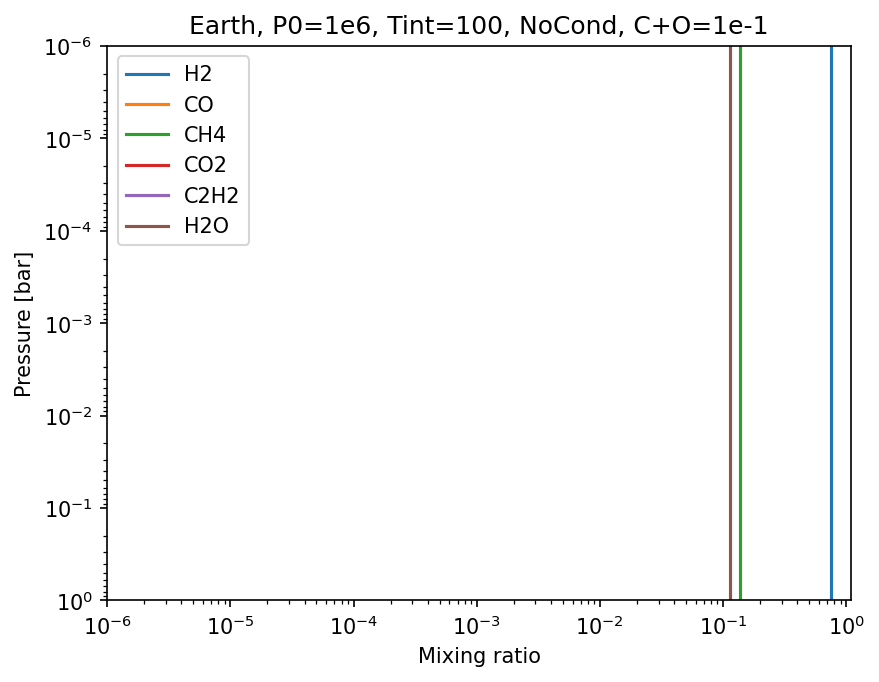

In [43]:
# plot mixing ratios for certain step
i = len(mols)-1
plot_mass_mr = False

threshold = None

if threshold is not None:
    mask = mols[i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

if plot_mass_mr:
    try:
        masses = [species_lib[name].weight for name in mol_names[mask]]
    except:
        raise KeyError("Error calculating mass: molecule name not found.")

    plt.plot(mols[i][:,mask]*masses/mus[i][:,None], PTs[i][:,0], label=mol_names[mask])
else:
    plt.plot(mols[i][:,mask], PTs[i][:,0], label=mol_names[mask])

xlog = True
if xlog:
    plt.xscale('log')
    plt.xlim(1e-6, 1.1e0)
else:
    plt.xlim(0, 1.05)

plt.yscale('log')
plt.ylim(PTs[0][0,0], PTs[0][-1,0]*1e1)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name)

plt.legend()

(5, 6)


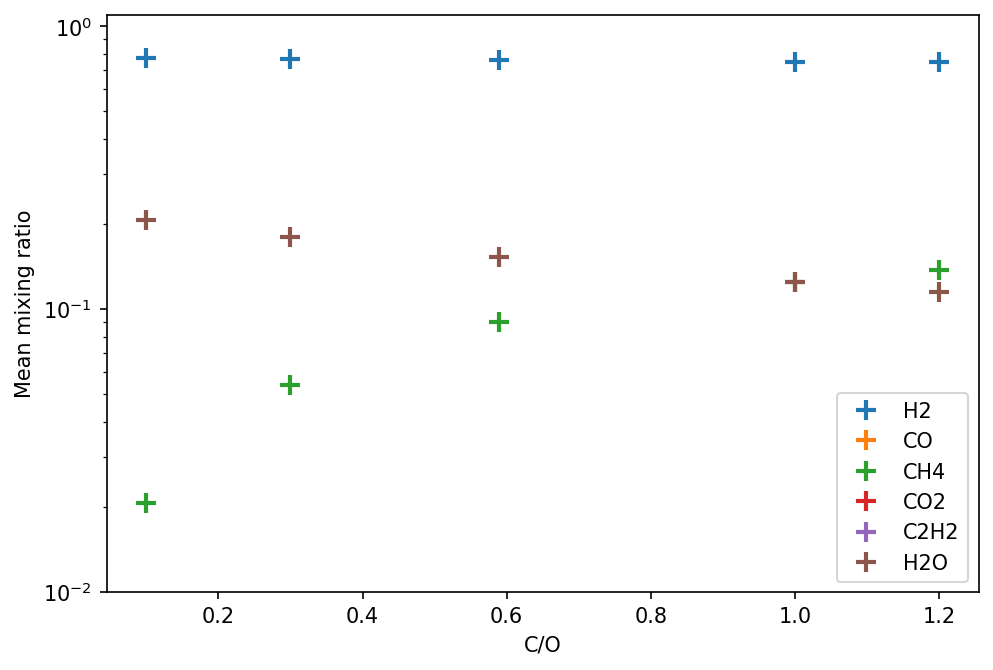

In [48]:
# plot mean mixing ratios dep. on loop_over variable

threshold = None

if threshold is not None:
    mask = np.zeros(mols[0].shape[1], dtype=bool)
    for i in range(len(mols)):
        new_mask = mols[i] > threshold
        new_mask = np.any(new_mask, axis=0)
        mask = np.logical_or(mask, new_mask)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(mols[i][:,mask].max(axis=0))[::-1]

mean_mols = []

for i in range(len(mols)):
    # maybe log mean?
    mean_mols.append(np.mean(mols[i][:,mask], axis=0))

mean_mols = np.array(mean_mols)
print(mean_mols.shape)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

for i in range(mean_mols.shape[1]):
    ax.plot(loop_overs, mean_mols[:,i], '+', label=mol_names[mask][i], ms=10, mew=2)

log_x = np.abs(np.log10(loop_overs[-1])-np.log10(loop_overs[0])) > 2
if log_x:
    ax.set_xscale('log')

ax.set_yscale('log')
ax.set_ylim(1e-2, 1.1e0)

ax.set_xlabel(loop_name.replace('plus', '+').replace('to', '/'))
ax.set_ylabel('Mean mixing ratio')
ax.legend()
